In [1]:
import uproot
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from collections import Counter

%matplotlib inline

In [2]:
def path_generator(t:str, eda=True) -> list:
    '''
    Approximately (size of 50 QCD dataset) == (size of 14 Hbb dataset)
    '''
    lst = []
    
    if t.upper() == 'QCD':
        main = '/home/h8lee/teams/DSC180A_FA21_A00/a11/train_mass_qcd/\
QCD_HT{low}to{high}_TuneCP5_13TeV-madgraph-pythia8/'
        if eda:
            num_data = 10 
        
        bounds = [
            [1000,1500],
            [1500,2000],
            [2000, 'Inf'],
            [500,700],
            [700,1000]
        ]
        
        for bound in bounds:
            low, high = bound
            fp = main.format(low=low, high=high)
            all_files = os.listdir(fp)
            all_files_fp = [fp + f for f in all_files]
            samples = random.sample(all_files_fp, k=num_data)
            
            # There's this one hidden file under (700-1000) bound
            while '.nano_mc2017_174_Skim.root.ViGCYO' in samples:
                samples = random.sample(all_files_fp, k=num_data) # Re-sample

            lst += samples # In total, randomly generate filepaths to 50 different QCD .root files
    elif t.upper() == 'HBB':
        main = '/home/h8lee/teams/DSC180A_FA21_A00/a11/train_mass_hbb/\
BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part{}_TuneCP5_13TeV-madgraph_pythia8/'
        if eda:
            num_data = 4
            
        parts = [1,2]
        
        for part in parts:
            # Since files in Hbb directory1 are smaller than those in Hbb directory2, 
            # sample more from directory1 to balance size of samples generating from 
            # directory2
            # (11 .root files in dir1) == (3 .root files in dir2)
            
#             if part==1:
#                 num_data = 11
#             else:
#                 num_data = 3
                
            fp = main.format(part)
            all_files = os.listdir(fp)
            samples = random.sample(all_files, k=num_data)
            files = [os.path.join(fp, sample) for sample in samples]
            
            lst += files
    return lst

In [3]:
qcd_eda_sets = path_generator('QCD', eda=True)
hbb_eda_sets = path_generator('hbb', eda=True)

In [4]:
def load_jet_features(fps):
    '''
    For all files at defined filepaths,
    extract jet features from each of them as well as their type
    '''
    jet_features = []
    unnecesssary_attrs = [
        'fj_idx',
        'fj_genRes_mass',
        'fj_lsf3'
    ]
    df = pd.DataFrame()
    
    for i in range(len(fps)):
        path = fps[i]
        f = uproot.open(path)
        tree = f['Events']
        
        if i==0:
            attrs = [branch.name for branch in tree.branches]
            jet_features += list(filter(lambda x:x.startswith('fj'), attrs))
            jet_features = [feat for feat in jet_features if feat not in unnecesssary_attrs] # drop sterile attributes
        
        features = tree.arrays(jet_features, library='np')
        df = pd.concat([df, pd.DataFrame(features)], axis=0)
        
    df = df.reset_index(drop=True)
    
    return df

-------

#### Validating the labels of QCD/signal jet samples

In [5]:
df_qcd = load_jet_features(qcd_eda_sets)
display(df_qcd.head())
print('\n', f'{df_qcd.shape[0]} randomly generated QCD jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,400.50,-1.977295,-3.072266,94.1250,84.562500,-1000.0,-1000.0,0.239518,0.013501,63.187500,...,-99.0,-99.0,1508.0,-310.0,467.0,2.919159,19.988342,0.261475,48.049858,-0.149885
1,305.50,-0.213806,-0.539429,68.4375,8.515625,-1000.0,-1000.0,0.000005,0.000109,11.320312,...,-99.0,-99.0,1508.0,-310.0,467.0,0.386322,19.988342,0.261475,48.049858,-2.682721
2,510.25,-1.650391,1.031006,214.6250,142.375000,-1000.0,-1000.0,0.931906,0.007165,133.875000,...,-99.0,-99.0,1668.0,1060.0,2856.0,-1.558350,62.780811,3.771484,81.247681,-1.915161
3,495.75,-1.653564,-2.175293,131.2500,0.609375,-1000.0,-1000.0,0.000090,0.084892,2.138672,...,-99.0,-99.0,1668.0,1060.0,2856.0,1.647949,62.780811,3.771484,81.247681,1.291138
4,685.00,-1.671387,1.073975,174.2500,80.562500,-1000.0,-1000.0,0.003541,0.002703,76.125000,...,-99.0,-99.0,1068.0,698.0,1536.0,-2.834229,8.435360,0.050934,34.060692,0.019531



 375774 randomly generated QCD jet samples


In [6]:
df_signal = load_jet_features(hbb_eda_sets)
display(df_signal.head())
print('\n', f'{df_signal.shape[0]} randomly generated signal jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,1472.0,0.506348,-1.967285,149.750,10.703125,-1000.0,-1000.0,0.000002,0.003351,6.328125,...,-99.0,-99.0,1452.0,191.5,1368.0,0.111328,42.983162,1.271484,18.629477,-1.773908
1,1303.0,-0.658936,1.231445,219.500,159.375000,-1000.0,-1000.0,0.000327,0.992766,158.625000,...,-99.0,-99.0,1452.0,191.5,1368.0,-3.087402,42.983162,1.271484,18.629477,1.310547
2,1750.0,-0.059731,0.198761,321.000,2.937500,-1000.0,-1000.0,0.000308,0.007938,1.802734,...,-99.0,-99.0,19072.0,3936.0,1988.0,2.536591,74.124413,1.847656,99.091156,-3.022980
3,1644.0,-0.657715,-2.906250,493.500,420.500000,-1000.0,-1000.0,0.066107,0.941508,438.750000,...,-99.0,-99.0,19072.0,3936.0,1988.0,-0.641584,74.124413,1.847656,99.091156,0.082031
4,1338.0,-0.167816,-3.049805,239.125,12.265625,-1000.0,-1000.0,0.228252,0.016427,18.093750,...,-99.0,-99.0,2760.0,-157.0,3416.0,-1.070295,22.150124,0.147095,172.879181,3.118561



 488716 randomly generated signal jet samples


#### Data validation

Validate the type of jets in our samples; each jet should only be associated to one unique type of QCD/signal

In [7]:
# QCD
# For this checkup, we only need label attribute

IS_QCDb = 'fj_isQCDb'
IS_QCDothers = 'fj_isQCDothers'
all_attrs = df_qcd.columns.tolist()
start_idx = all_attrs.index(IS_QCDb)
end_idx = all_attrs.index(IS_QCDothers)+1

qcd_labels = all_attrs[start_idx:end_idx]

In [8]:
df_qcd_labels = df_qcd[qcd_labels]
display(df_qcd_labels.head())

,fj_isQCDb,fj_isQCDbb,fj_isQCDc,fj_isQCDcc,fj_isQCDlep,fj_isQCDothers
0,0,0,0,0,0,1
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,1,0,0,0


In [9]:
# We want each jet corresponding to exactly one type

print(f'Each jet corresponds to exactly one type:\
 {len(df_qcd_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [10]:
# How many jets are there for different QCD types?

display(df_qcd_labels.sum(axis=0).sort_values(ascending=False).to_frame(name='Count'))

,Count
fj_isQCDothers,229069
fj_isQCDlep,81626
fj_isQCDcc,26146
fj_isQCDc,26124
fj_isQCDb,6552
fj_isQCDbb,6257


In [11]:
# Signal jets
# For this checkup, we only need label attribute

IS_HBB = 'fj_H_bb'
IS_HQQ = 'fj_H_qq'
all_attrs = df_signal.columns.tolist()
start_idx = all_attrs.index(IS_HBB)
end_idx = all_attrs.index(IS_HQQ)+1

signal_labels = all_attrs[start_idx:end_idx]

In [12]:
df_signal_labels = df_signal[signal_labels]

# We're only going to include signal jets
# of types H_bb, H_cc, H_qq for performing EDA
df_signal_labels = df_signal_labels[
    (df_signal_labels['fj_H_bb'] == 1) |
    (df_signal_labels['fj_H_cc'] == 1) |
    (df_signal_labels['fj_H_qq'] == 1)
]

# Drop observations that are associated to more than single type
df_signal_labels['temp'] = df_signal_labels['fj_H_bb'] + df_signal_labels['fj_H_cc'] + df_signal_labels['fj_H_qq']
print(f'Before filtering: {df_signal_labels.shape[0]} rows', '\n')

df_signal_labels = df_signal_labels[df_signal_labels['temp'] == 1].drop(columns='temp')
print(f'After filtering: {df_signal_labels.shape[0]} rows')

Before filtering: 462597 rows 

After filtering: 462555 rows


In [13]:
# We want each jet corresponding to exactly one type

print(f'Each jet corresponds to exactly one type:\
 {len(df_signal_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [14]:
# How many jets are there for each signal type?

display(df_signal_labels.sum(axis=0).sort_values(ascending=False).to_frame(name='Count'))

,Count
fj_H_cc,159807
fj_H_bb,159789
fj_H_qq,159476


------

#### EDA \#1

 Plot distribution of our target attribute(`fj_genjetmsd`), generator-level soft drop mass, of QCD jets according to their type

In [15]:
# Filtering using the validation results

signal_idx = df_signal_labels.index.tolist()
df_signal = df_signal.filter(items=signal_idx, axis=0)

In [16]:
# Create temporary `class` label to differentiate QCD jets from signal jets
# Then concatenate QCD dataset to signal dataset

df_qcd['Type'] = 'QCD'
df_signal['Type'] = 'Signal'

df_qcd_and_signal = pd.concat([df_qcd, df_signal], axis=0)
display(df_qcd_and_signal.head())

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi,Type
0,542.0,0.640747,1.734131,219.625,3.312500,-1000.0,-1000.0,0.010139,0.013712,262.750000,...,-99.0,960.0,264.000,2064.0,-1.591492,27.457170,0.775391,47.721760,-2.863281,QCD
1,406.5,-0.386230,-1.934814,204.000,185.750000,-1000.0,-1000.0,0.428652,0.010356,186.125000,...,-99.0,960.0,264.000,2064.0,2.077454,27.457170,0.775391,47.721760,0.805664,QCD
2,754.5,1.823486,-1.008789,270.000,1.124023,-1000.0,-1000.0,0.000051,0.004040,4.648438,...,-99.0,594.0,-42.375,626.0,-3.045881,89.157814,12.125000,94.873680,-3.023908,QCD
3,655.0,-0.609375,2.122559,142.750,0.982422,-1000.0,-1000.0,0.000155,0.001535,1.876953,...,-99.0,594.0,-42.375,626.0,0.105957,89.157814,12.125000,94.873680,0.127930,QCD
4,608.5,-1.126221,0.986084,481.250,484.500000,-1000.0,-1000.0,0.002386,0.003743,453.250000,...,-99.0,1476.0,986.000,1976.0,-0.289673,13.106502,0.070618,53.865387,-0.315796,QCD


In [17]:
df_qcd_and_signal['Type'].value_counts()

Signal    479072
QCD       375355
Name: Type, dtype: int64

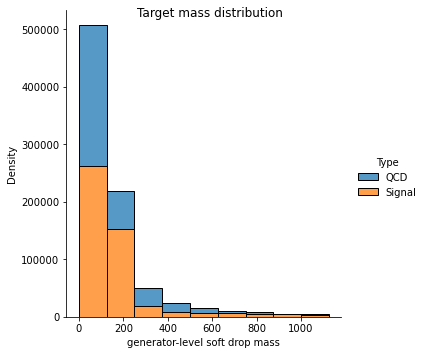

In [18]:
# Used `.displot()` from seaborn for visualization

ax = sns.displot(x='fj_genjetmsd', data=df_qcd_and_signal, hue='Type',
                bins=range(0, 1250, 125), multiple='stack')

ax.set_axis_labels('generator-level soft drop mass', 'Density');
ax.fig.suptitle('Target mass distribution');

-------

In [25]:
# BELOW COULD BE USED FOR VALIDATION OF signal jets DATASET

# Hbb jets are known to be the most common type of 
# jet that contains Higgs boson
# This is because Higgs boson is more likely to decay into
# *exactly* two b-quarks in a single proton-proton event
# These b quarks are known for their relatively heavier weights
# compared to other elementary particles
# which gives them longer lifespan 
# One conspicuous characteristic of Hbb jets
# is hence their long lifespan
# which is enabled by heavy weights of Higgs boson and its decay product, b quarks
# Let's now explore if this finding holds in our datset
# using `fj_genjetmsd` attribute

# Does above trend hold for QCD jets also?
# i.e. Do certain types of QCD jet tend to be heavier than otehr types?

### EDA \#2 -- QCD

 Does presence of secondary vertices in a jet have any effect on jet mass?

In [19]:
def load_num_sv(fps):
    '''
    For all files at defined filepaths,
    extract secondary vertex features from 
    each of the file
    '''
    NUMPY = 'np'
    SV_PT_LOG = 'sv_pt_log'
    FJ_GENJETMSD = 'fj_genjetmsd'
    num_svs = []
    jet_mass = []
    
    for i in range(len(fps)):
        path = fps[i]
        f = uproot.open(path)
        tree = f['Events']
        sv_pt_logs = tree.arrays(SV_PT_LOG, library=NUMPY)[SV_PT_LOG]
        num_sv = list(map(lambda sublst: len(list(filter(lambda x: x != 0, sublst))), sv_pt_logs))
        num_svs += num_sv
        
        # Jet masses(target)
        masses = tree.arrays(FJ_GENJETMSD, library=NUMPY)[FJ_GENJETMSD].tolist()
        jet_mass += masses
        
#     df = df.reset_index(drop=True)
    
    return num_svs, jet_mass

In [59]:
# QCD

qcd_num_svs, qcd_jet_mass = load_num_sv(qcd_eda_sets)

avg_qcd_num_svs = np.mean(qcd_num_svs)
avg_qcd_jet_mass = np.mean(qcd_jet_mass)

med_qcd_num_svs = np.median(qcd_num_svs)
med_qcd_jet_mass = np.median(qcd_jet_mass)

qcd_num_svs_counter = Counter(qcd_num_svs)
temp = qcd_num_svs_counter.items()
qcd_num_svs_counts = sorted(temp, reverse=True, key=lambda x:x[1])
# Later create 2 x 2 dataframe; indexing QCD and Signal, columns of mean, median

In [68]:
df_qcd_num_svs_counts = pd.DataFrame(qcd_num_svs_counts,
                                     columns=['# of SVs in a jet', 'counts'],
                                    ).set_index('# of SVs in a jet')

display(df_qcd_num_svs_counts)
print(f'Majority of QCD jets in our data has no to only few secondary vertex\
 recorded', '\n')

,counts
# of SVs in a jet,
0,136230
1,121613
2,66522
3,30217
4,12459
5,4997
6,1995
7,1322


Majority of QCD jets in our data has no to only few secondary vertex recorded 



In [70]:
qcd_dict = {
    '# of SVs recorded':qcd_num_svs,
    'generator-level soft drop mass':qcd_jet_mass
}

qcd_df = pd.DataFrame(qcd_dict)
display(qcd_df.head())

,# of SVs recorded,generator-level soft drop mass
0,1,262.750000
1,2,186.125000
2,0,4.648438
3,0,1.876953
4,2,453.250000


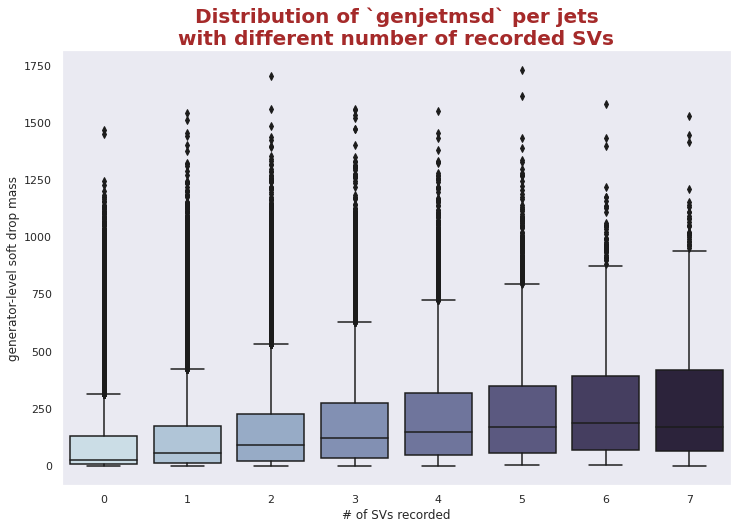

In [92]:
# Boxplot to show relationship between them

_ = sns.set(rc={'figure.figsize':(12,8)})

qcd_box = sns.boxplot(x='# of SVs recorded',
           y='generator-level soft drop mass',
           data=qcd_df, palette='ch:s=.25,rot=-.25')

_ = qcd_box.grid(False)
TITLE = 'Distribution of `genjetmsd` per jets\nwith different number of recorded SVs'
_ = qcd_box.set_title(TITLE, fontdict={'size':20, 'weight':'bold', 'color':'brown'})

-----

In [20]:
# Only need subset of attributes for this part of EDA
# Maximize memory(space) efficiency

eda1_attrs = [
    'fj_pt',
    'fj_msoftdrop',
    'fj_genRes_mass',
    'fj_eta',
    'fj_genjetmsd'
]

df_qcd_eda1 = df_qcd[eda1_attrs]
print(f'Before filterting: {df_qcd_eda1.shape[0]} observations', '\n')

# Data filtering
# df_qcd_eda1 = df_qcd_eda1.apply(filter_jet, axis=1)
# df_qcd_eda1 = df_qcd_eda1[df_qcd_eda1['filter'] == 1]
# print(f'After filterting: {df_qcd_eda1.shape[0]} observations')

Before filterting: 375479 observations 



In [21]:
ax = sns.displot(df_qcd_eda1[TARGET], kde=False, bins=20);
    sns.displot(df_signal[TARGET], bins=20)

IndentationError: unexpected indent (<ipython-input-21-166f582302a7>, line 2)

In [15]:
df_hbb = load_jet_features(hbb_eda_sets)

In [18]:
# Check if the size of samples we have for QCD and Hbb
# are apporoximately equivalent to minimize bias factors

epoch = 10
qcd_size = []
hbb_size = []

for _ in range(epoch):
    df_qcd = load_jet_features(qcd_eda_sets)
    df_hbb = load_jet_features(hbb_eda_sets)
    
    qcd_size.append(df_qcd.size)
    hbb_size.append(df_hbb.size)

In [21]:
np.average(qcd_size), np.average(hbb_size)

(22530780.0, 34830540.0)

-------